# Intelligent Agents: Reflex Agents for the Vacuum-cleaner World


## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square is cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can `clean` the current square or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
from numpy import random

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return random.choice(actions)

In [2]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'east'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

This simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns the performance measure which is here the number of cleaned squares (since all squares are constantly dirty, it is the number of `suck` actions by the agent). 

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned
        


Do one simulation run with 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: north
step 2 - action: east
step 3 - action: east
step 4 - action: west
step 5 - action: east
step 6 - action: suck
step 7 - action: north
step 8 - action: suck
step 9 - action: suck
step 10 - action: south
step 11 - action: suck
step 12 - action: west
step 13 - action: east
step 14 - action: west
step 15 - action: east
step 16 - action: east
step 17 - action: west
step 18 - action: south
step 19 - action: suck


5

# Tasks

_Submission Instructions:_ Use this notebook to prepare your submission. Complete this section with your code and results. You can add additional Markdown blocks for your description, comments in the code and use mathplotlib to produce charts. 

_Note:_ Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design. 


## Task 1: Implement a simulation environment [2 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty.
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment needs to work with the simple randomized agent program from above and then it can be used for your agent implementation in the tasks below.

In [5]:
import numpy

actions = ["north", "east", "south", "west", "suck"]

# The task function calls an agent function on the environment.
# Internally, the environment is stored as a series of variables corresponding
# to the PEAS descriptors. The environment is represented by a 2D array, in
# which 1s represent dirty squares and 0s represent clean squares. Additional
# variables track the position of the agent and the remaining number of dirty
# squares. Th function returns the performance measure.

def task(agent, size, max_steps):
    performance = 0
    environment = numpy.random.randint(5, size=(size,size))//4
    bumpers = {
        "north" : False,
        "east" : False,
        "south" : False,
        "west" : False,
    }
    dirty = False
    dirty_squares = 0
    y = 0
    x = 0

    # initialize count of dirty squares
    for i in range(size):
        for j in range(size):
            if environment[i,j] == 1:
                dirty_squares += 1

    for i in range(max_steps):
        # update sensors
        bumpers["north"] = y == 0
        bumpers["east"] = x == size - 1
        bumpers["south"] = y == size - 1
        bumpers["west"] = x == 0
        dirty = environment[y,x] == 1

        # retrieve action from agent
        action = agent(bumpers, dirty)

        # perform action
        if action == "suck" and dirty:
            dirty_squares -= 1
            environment[y,x] = 0            
        elif action == "north" and not bumpers["north"]:
            y -= 1
        elif action == "east" and not bumpers["east"]:
            x += 1
        elif action == "south" and not bumpers["south"]:
            y += 1
        elif action == "west" and not bumpers["west"]:
            x -= 1
        performance += 1

        # complete task if environment is clean        
        if dirty_squares == 0:
            return performance

    return max_steps

## Task 2:  Implement a simple reflex agent [1 Point] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ The agent cannot directly use variable in the environment. It only gets the percepts as the arguments to the agent program function.

In [6]:
def simple_reflex_agent(bumpers, dirty):
    if dirty:
        return actions[4]
    else:
        options = actions.copy()
        options.remove("suck")
        for option in options:
            if bumpers[option]:
                options.remove(option)
        return numpy.random.choice(options)

## Task 3: Implement a model-based reflex agent [3 Point]

This agent keeps track of the location and remembers where it has cleaned. Assume the agent knows how many squares the room has. It can move to a corner to determine its location and then is able to use more advanced navigation.

Describe how you define the __agent state__ and how your agent works before implementing it. _Note on implementing the state in Python:_ [Examples](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)

This model-based reflex agent is implemented as a functor instead of a function. Because functors are objects treated as function, they have the abilty to maintain a state which can change its behavior in between calls. This state is suitable for maintaining a model of some observable environment. The agent itself will implement a cleaning strategy in which it traverses the environment row by row and cleans in a snake-like, winding pattern. The model will store the current position of the agent as an x and y coordinate. Before the agent locates a corner, the position is indeterminate. After a corner is found, the agent will know its position and execute the cleaning strategy.

In [7]:
class ModelBasedReflexAgent:
    def __init__(self):
        self.y = -1
        self.x = -1

    def __call__(self, bumpers, dirty):
        # When north bumper is triggered, agent is on the northern edge.
        if bumpers["north"]:
            self.y = 0
        # When west bumper is triggered, the agent is on the western edge.
        if bumpers["west"]:
            self.x = 0
        
        # If coordinates are indeterminate, move towards the northwest corner.
        if self.y == -1:
            return actions[0]
        elif self.x == -1:
            return actions[3]
        
        # After position has been determined, the agent moves east on even-index
        # rows and west on odd-index rows to clean in a zig-zag pattern. When
        # the end of a row is reached and a bumper is triggered, the agent moves
        # south.
        if dirty:
            return actions[4]
        elif self.y % 2:
            if bumpers["west"]:
                self.y += 1
                return actions[2]
            else:
                self.x -= 1
                return actions[3]
        else:
            if bumpers["east"]:
                self.y += 1
                return actions[2]
            else:
                self.x += 1
                return actions[1]

## Task 4: Simulation study [3 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results in a suitable format (tables, graphs) and discuss the differences. 

Here is some help with [charts and tables.](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/charts_and_tables.ipynb)

In [8]:
import pandas

average_performances = pandas.DataFrame(columns=["Size", "Randomized Agent", "Simple Reflex Agent", "Model-Based Reflex Agent"], dtype="int64")
max_steps = 2 ** 28
for i in range(2, 8):
    size = 2 ** i
    dataframe = pandas.DataFrame(columns=["Size", "Randomized Agent", "Simple Reflex Agent", "Model-Based Reflex Agent"], dtype="int64")
    for i in range(100):
        model_based_reflex_agent = ModelBasedReflexAgent()
        performance = {
            "Size" : f'{size} x {size}',
            "Randomized Agent" : task(simple_randomized_agent, size, max_steps),
            "Simple Reflex Agent" : task(simple_reflex_agent, size, max_steps),
            "Model-Based Reflex Agent" : task(model_based_reflex_agent, size, max_steps)
        }
        dataframe = dataframe.append(performance, ignore_index=True)
    averages = {
        "Size" : f'{size} x {size}',
        "Randomized Agent" : dataframe["Randomized Agent"].mean(),
        "Simple Reflex Agent" : dataframe["Simple Reflex Agent"].mean(),
        "Model-Based Reflex Agent" : dataframe["Model-Based Reflex Agent"].mean()
    }
    average_performances = average_performances.append(averages, ignore_index = True)

In [9]:
print("Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):")

average_performances

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):


,Size,Randomized Agent,Simple Reflex Agent,Model-Based Reflex Agent
0,4 x 4,232.04,47.34,14.55
1,8 x 8,1600.22,493.17,72.10
2,16 x 16,10257.04,3446.85,301.98
3,32 x 32,57048.57,19599.83,1224.24
4,64 x 64,291626.53,116073.96,4913.46
5,128 x 128,1474832.95,632331.59,19650.99


<Figure size 432x288 with 0 Axes>

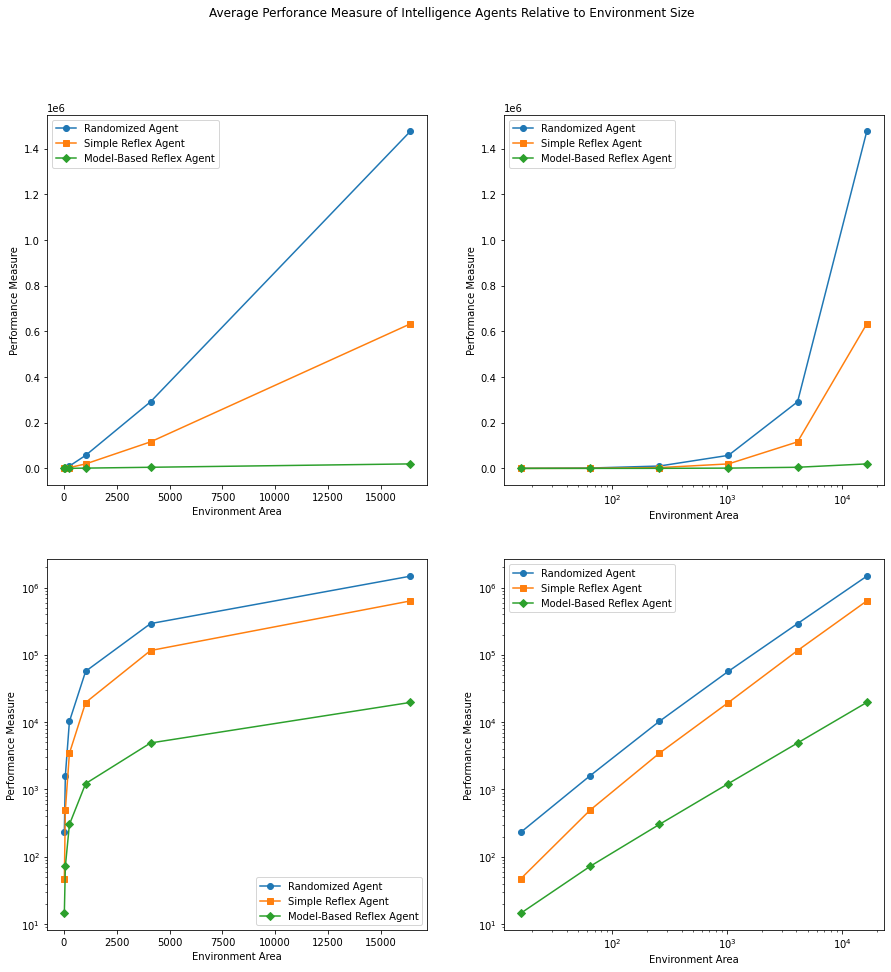

In [10]:
from matplotlib import pyplot

pyplot.figure()
pyplot.subplots(figsize = (15, 15))
pyplot.suptitle("Average Perforance Measure of Intelligence Agents Relative to Environment Size")

pyplot.subplot(2,2,1)
pyplot.xlabel("Environment Area")
pyplot.ylabel("Performance Measure")
pyplot.plot([4**i for i in range(2,8)], average_performances["Randomized Agent"], marker="o", label="Randomized Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Simple Reflex Agent"], marker="s", label="Simple Reflex Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Model-Based Reflex Agent"], marker="D", label="Model-Based Reflex Agent")
pyplot.legend()

pyplot.subplot(2,2,2)
pyplot.xlabel("Environment Area")
pyplot.ylabel("Performance Measure")
pyplot.xscale('log')
pyplot.plot([4**i for i in range(2,8)], average_performances["Randomized Agent"], marker="o", label="Randomized Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Simple Reflex Agent"], marker="s", label="Simple Reflex Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Model-Based Reflex Agent"], marker="D", label="Model-Based Reflex Agent")
pyplot.legend()

pyplot.subplot(2,2,3)
pyplot.xlabel("Environment Area")
pyplot.ylabel("Performance Measure")
pyplot.yscale('log')
pyplot.plot([4**i for i in range(2,8)], average_performances["Randomized Agent"], marker="o", label="Randomized Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Simple Reflex Agent"], marker="s", label="Simple Reflex Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Model-Based Reflex Agent"], marker="D", label="Model-Based Reflex Agent")
pyplot.legend()

pyplot.subplot(2,2,4)
pyplot.xlabel("Environment Area")
pyplot.ylabel("Performance Measure")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.plot([4**i for i in range(2,8)], average_performances["Randomized Agent"], marker="o", label="Randomized Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Simple Reflex Agent"], marker="s", label="Simple Reflex Agent")
pyplot.plot([4**i for i in range(2,8)], average_performances["Model-Based Reflex Agent"], marker="D", label="Model-Based Reflex Agent")
pyplot.legend()

As would be expected, the model-based reflex agent far outperforms the randomized and simple reflex agents. The model-based agent's performance metric increases approximately linearly with the size of the environment area. The randomized and simple agents' performance metrics increase with an approximately polynomial relationship to the size of the environment. Note on the loglog plot, the performance metric of the randomized agent appears to approach the simple reflex agent. This may be because on larger environments, there is a smaller proportion of edge squares to total squares, reducing the likelihood of the randomized agent performing a useless movement action.

## Task 5: Robustness of the agent implementations [1 Point] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In any rectangular room, the agent implementations are expected to have relative performance similar to their performance in square rooms. The model-based agent traverses the room row by row. Thus, it travels to each location in the room only once, finishing its task with linear time complexity. However, it's possible this implementation of a model-based agent may never complete the task in irregularly shaped environments or environments containing obstacles. This is because whenever its eastern or western bumpers are triggered, it moves south to the next row, possibly missing dirty squares behind an obstacle or wall. In such scenarios, the randomized agents are more likely to succeed, as eventually they will suck dirt off of every single square in the environment.

## Graduate student advanced task: Obstacles [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [11]:
import numpy

actions = ["north", "east", "south", "west", "suck"]

# The task function calls an agent function on the environment. Internally, the
# environment is stored as a series of variables corresponding to the PEAS
# descriptors. The environment is represented by a 2D array, in which 2s
# represent an obstacle, 1s represent dirty squares, and 0s represent clean
# squares. When the environment is created, 20% of squares are obstacles, 20%
# of squares are dirty, and 60% of squares are clean. Additional variables
# track the position of the agent and the remaining number of dirty squares.
# The function returns the performance measure.

def task(agent, size, max_steps):
    performance = 0
    environment = numpy.clip(numpy.random.randint(5, size=(size,size)) - 2, 0, 2)
    bumpers = {
        "north" : False,
        "east" : False,
        "south" : False,
        "west" : False,
    }
    dirty = False
    dirty_squares = 0
    y = 0
    x = 0

    # initialize count of dirty squares
    for i in range(size):
        for j in range(size):
            if environment[i,j] == 1:
                dirty_squares += 1

    for i in range(max_steps):
        # update north bumper
        if y == 0:
            bumpers["north"] = True
        elif environment[y-1,x] == 2:
            bumpers["north"] = True
        else:
            bumpers["north"] = False

        # update east bumper
        if x == size - 1:
            bumpers["east"] = True
        elif environment[y,x+1] == 2:
            bumpers["east"] = True
        else:
            bumpers["east"] = False

        # update south bumper
        if y == size - 1:
            bumpers["south"] = True
        elif environment[y+1,x] == 2:
            bumpers["south"] = True
        else:
            bumpers["south"] = False
        
        # update west bumper
        if x == 0:
            bumpers["west"] = True
        if environment[y,x-1] == 2:
            bumpers["west"] = True
        else:
            bumpers["west"] = False

        # update dirt sensor
        dirty = environment[y,x] == 1

        # retrieve action from agent
        action = agent(bumpers, dirty)

        # perform action
        if action == "suck" and dirty:
            dirty_squares -= 1
            environment[y,x] = 0            
        elif action == "north" and not bumpers["north"]:
            y -= 1
        elif action == "east" and not bumpers["east"]:
            x += 1
        elif action == "south" and not bumpers["south"]:
            y += 1
        elif action == "west" and not bumpers["west"]:
            x -= 1
        performance += 1

        # complete task if environment is clean        
        if dirty_squares == 0:
            return performance

    return max_steps

The new task environment is now 20% obstacle squares which cannot be traverse and will trigger the bumper sensors. Modifications of the task function were made to implement this. Changes include adjusting initilization to include 2s in the environemnt array and checking for 2s adjacent to the agent's current position when updating the bumpers.

In order for the model-based agent to perform in this new environment, a different strategy is needed. It is helpful to treat the environment and its squares as a graph of nodes. This way, cleaning the room becomes a graph traversal problem. Depth-first search is most suitable, because the agent is only capable of immediately traveling to adjacent squares. The model would need to store a stack of movements it has made and record all squares already explored. When determining an action to take, the agent will suck if it detects dirt like it did before. If the agent does not detect dirt, it will move in the direction of a square it has not previously occupied. If no such squares exist, the agent will pop its last movement from the stack and backtrack.

This new model-cased reflex agent is implemented below.

In [12]:
from collections import deque

class ModelBasedReflexAgent:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.stack = deque()
        self.traversed = {(0,0)}
        self.move = actions.copy()
        move.remove("suck")

    def __call__(self, bumpers, dirty):
        traversed.add((x,y))

        # If square is dirty, suck.
        if dirty:
            return action[4]
        # If the square isn't dirty, move to an unobstructed square
        # that the agent has not previously been to.
        elif not bumpers["north"] and (x,y+1) not in traversed:
            stack.append(0)
            y += 1
            return action[0]
        elif not bumpers["east"] and (x+1,y) not in traversed:
            stack.append(1)
            x += 1
            return action[1]
        elif not bumpers["south"] and (x,y-1) not in traversed:
            stack.append(2)
            y -= 1
            return action[2]
        elif not bumpers["west"] and (x-1,y) not in traversed:
            stack.append(3)
            x -= 1
            return action[3]
        # If no such squares exist, backtrack by traveling in
        # the opposite direction of last movement.
        else:
            return move[stack.pop() - 1]        

## More advanced tasks to think about

You can think about these:

* __Unknown environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square.

* __Utility-based agent:__ Change the environment, so each square has a fixed probability of getting dirty again. We assume the agent has learned this information over time. For the implementation, we give this information to the agent as a 2-dimensional array of probabilities  Cleaning one dirty square produces a utility of 1. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 10000 time steps. This is very tricky!

In [13]:
# Your ideas/code